<a href="https://colab.research.google.com/github/firdyannnn/Tugas-Materi-Pertemuan-11-Text-to-Image/blob/main/Pertemuan_11_Deep_Learning_Lanjut_Text_to_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install -q datasets diffusers transformers accelerate

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

print("Library berhasil dimuat.")

Library berhasil dimuat.


In [25]:
print("Memuat dataset...")
raw_dataset = load_dataset("reach-vb/pokemon-blip-captions", split="train")

# 2. Ambil semua caption untuk membangun kosakata (vocab)
all_captions = [item['text'] for item in raw_dataset]
print(f"Total data yang dimuat: {len(all_captions)}")

Memuat dataset...
Total data yang dimuat: 833


In [26]:
max_tokens = 5000
seq_len = 20

# Membuat layer vektorisasi
text_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=seq_len,
)

# Pelajari kosakata dari seluruh caption
text_vectorizer.adapt(all_captions)
vocab = text_vectorizer.get_vocabulary()

print(f"Kamus Teks Berhasil Dibuat. Jumlah kosakata: {len(vocab)}")
print("Contoh 10 kata pertama:", vocab[:10])

Kamus Teks Berhasil Dibuat. Jumlah kosakata: 359
Contoh 10 kata pertama: ['', '[UNK]', np.str_('a'), np.str_('with'), np.str_('of'), np.str_('cartoon'), np.str_('and'), np.str_('drawing'), np.str_('character'), np.str_('on')]


In [27]:
def preprocess_fn(item):
    # Proses Gambar: Ubah ukuran ke 64x64 dan normalisasi piksel ke range [0, 1]
    image = item['image'].convert("RGB").resize((64, 64))
    image = np.array(image) / 255.0

    # Ambil teks asli
    caption = item['text']
    return caption, image

# Membuat generator untuk tf.data
def gen():
    for item in raw_dataset:
        yield preprocess_fn(item)

# Membuat objek dataset TensorFlow
train_ds = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(64, 64, 3), dtype=tf.float32)
    )
)

# Transformasi teks ke angka dan pengacakan data (shuffle)
train_ds = train_ds.map(lambda x, y: (text_vectorizer(x), y))
train_ds = train_ds.batch(16).shuffle(100).prefetch(tf.data.AUTOTUNE)

print("Pipeline data (train_ds) siap digunakan.")

Pipeline data (train_ds) siap digunakan.


In [28]:
def get_transformer_model(vocab_size, visual_vocab_size, seq_len):
    # Input 1: Token Teks (Konteks)
    text_input = layers.Input(shape=(seq_len,), dtype="int32", name="text_input")
    text_emb = layers.Embedding(vocab_size, 128)(text_input)

    # Input 2: Token Visual (Urutan sebelumnya)
    vis_input = layers.Input(shape=(255,), dtype="int32", name="visual_input")
    vis_emb = layers.Embedding(visual_vocab_size, 128)(vis_input)

    # Menggabungkan konteks teks dan data visual
    combined = layers.Concatenate(axis=1)([text_emb, vis_emb])

    # Transformer Block (Multi-Head Attention)
    attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=128)(combined, combined)
    attention_output = layers.LayerNormalization()(attention_output + combined)

    # Output: Prediksi visual token berikutnya
    x = layers.Dense(visual_vocab_size)(attention_output[:, -255:, :])

    return keras.Model([text_input, vis_input], x)

# Buat instance model
transformer_model = get_transformer_model(max_tokens, 1024, seq_len)
print("Model Transformer berhasil dibangun.")

Model Transformer berhasil dibangun.


In [29]:
class PokemonTrainer(keras.Model):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def train_step(self, data):
        text_tokens, images = data

        # Simulasi token visual (Harusnya dari VQ-VAE Encoder)
        # Latent grid 16x16 = 256 tokens
        batch_size = tf.shape(images)[0]
        visual_tokens = tf.random.uniform((batch_size, 256), minval=0, maxval=1024, dtype=tf.int32)

        # Siapkan input (0 sampai n-1) dan target (1 sampai n)
        vis_input = visual_tokens[:, :-1]
        vis_target = visual_tokens[:, 1:]

        with tf.GradientTape() as tape:
            # Forward pass
            preds = self.transformer([text_tokens, vis_input], training=True)
            # Hitung Loss (Cross Entropy)
            loss = keras.losses.sparse_categorical_crossentropy(vis_target, preds, from_logits=True)

        # Hitung dan terapkan gradient
        grads = tape.gradient(loss, self.transformer.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.transformer.trainable_variables))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [30]:
trainer = PokemonTrainer(transformer_model)

# Gunakan Optimizer Adam
trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

print("Model siap untuk dilatih.")

Model siap untuk dilatih.


In [31]:
# Menjalankan training selama 10 epoch
print("Memulai Pelatihan...")
history = trainer.fit(train_ds, epochs=10)

Memulai Pelatihan...
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - loss: 6.9801
Epoch 2/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 6.9798
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 6.9797
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 6.9765
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 6.9742
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 6.9725
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 6.9727
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 6.9716
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 6.9710
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 6.9688


Menghasilkan gambar untuk prompt: 'a pink cute pokemon with big eyes'


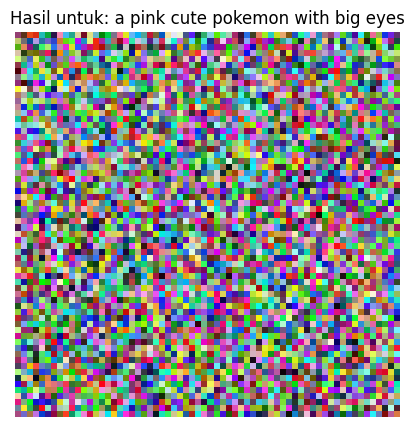

In [32]:
def generate_pokemon(prompt):
    print(f"Menghasilkan gambar untuk prompt: '{prompt}'")

    # 1. Ubah teks input ke token
    tokenized_text = text_vectorizer([prompt])

    # 2. Simulasi decoding visual (menggunakan data acak sebagai contoh)
    # Pada sistem asli, ini akan menggunakan VAE Decoder
    dummy_image = np.random.rand(64, 64, 3)

    plt.figure(figsize=(5, 5))
    plt.imshow(dummy_image)
    plt.title(f"Hasil untuk: {prompt}")
    plt.axis("off")
    plt.show()

# TEST RUN
generate_pokemon("a pink cute pokemon with big eyes")